# GNN Experiment — Corrected DRE Setup

Three methods compared (all β=0.15, α=0.10):

| Method | Classifier | DRE input | DRE PCA | DRE clip |
|--------|-----------|-----------|---------|----------|
| **A** | LR (7× binary, 1024-dim) | 1024-dim scaled features | PCA(4) | None |
| **B** | LR (7× binary, 1024-dim) | 1024-dim scaled features | None | None |
| **C** | GNN (joint 7-label, 1024-dim) | **7-dim GNN probs** | None | None |

All three feed their probabilities `[N, 7]` into `PerPathologySCRCPredictor`.

A vs B isolates the effect of PCA in the DRE (same LR classifier).  
B vs C isolates the effect of feature space (1024-dim vs 7-dim) and classifier (LR vs GNN).

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

ROOT = Path("../..").resolve()
if str(ROOT / "src") not in sys.path:
    sys.path.insert(0, str(ROOT / "src"))

from wcp_l2d.dre import AdaptiveDRE
from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.gnn import build_adjacency_matrix, train_gnn
from wcp_l2d.pathologies import COMMON_PATHOLOGIES
from wcp_l2d.scrc import PerPathologySCRCPredictor

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

K = len(COMMON_PATHOLOGIES)
print("Pathologies:", COMMON_PATHOLOGIES)
print("Device:", "mps" if torch.backends.mps.is_available() else "cpu")

Pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Pneumonia', 'Pneumothorax']
Device: mps


## 1. Load pre-extracted features

In [2]:
FEAT_DIR = ROOT / "data" / "features"

chex = ExtractedFeatures.load(FEAT_DIR / "chexpert_densenet121-res224-chex_features.npz")
nih  = ExtractedFeatures.load(FEAT_DIR / "nih_densenet121-res224-chex_features.npz")

print(f"CheXpert  features: {chex.features.shape}  labels: {chex.labels.shape}")
print(f"NIH       features: {nih.features.shape}   labels: {nih.labels.shape}")

CheXpert  features: (64534, 1024)  labels: (64534, 7)
NIH       features: (30805, 1024)   labels: (30805, 7)


## 2. Train / Cal / Test splits

In [3]:
rng = np.random.RandomState(SEED)

N_chex = len(chex.features)
idx = rng.permutation(N_chex)
n_train = int(0.60 * N_chex)
n_cal   = int(0.20 * N_chex)

train_idx = idx[:n_train]
cal_idx   = idx[n_train:n_train + n_cal]
test_idx  = idx[n_train + n_cal:]

X_train, Y_train = chex.features[train_idx], chex.labels[train_idx]
X_cal,   Y_cal   = chex.features[cal_idx],   chex.labels[cal_idx]
X_test,  Y_test  = chex.features[test_idx],  chex.labels[test_idx]

# NIH: 50% unlabeled pool for DRE, 50% labeled test
N_nih = len(nih.features)
nih_idx = rng.permutation(N_nih)
n_pool  = N_nih // 2

pool_idx     = nih_idx[:n_pool]
nih_test_idx = nih_idx[n_pool:]

X_pool             = nih.features[pool_idx]
X_nih_test, Y_nih_test = nih.features[nih_test_idx], nih.labels[nih_test_idx]

print(f"CheXpert  train={len(X_train)}  cal={len(X_cal)}  test={len(X_test)}")
print(f"NIH       pool={len(X_pool)}    test={len(X_nih_test)}")

CheXpert  train=38720  cal=12906  test=12908
NIH       pool=15402    test=15403


## 3. StandardScaler + 7 binary LR classifiers

In [4]:
# StandardScaler fitted on training set; applied to all splits
scaler = StandardScaler().fit(X_train)
Xtr_s   = scaler.transform(X_train)
Xcal_s  = scaler.transform(X_cal)
Xtest_s = scaler.transform(X_test)
Xnih_s  = scaler.transform(X_nih_test)
Xpool_s = scaler.transform(X_pool)

# Train 7 independent binary LRs on 1024-dim scaled features
lrs = []
for k, path in enumerate(COMMON_PATHOLOGIES):
    valid = ~np.isnan(Y_train[:, k])
    if valid.sum() < 10 or len(np.unique(Y_train[valid, k])) < 2:
        lrs.append(None)
        continue
    lr = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=SEED)
    lr.fit(Xtr_s[valid], Y_train[valid, k].astype(int))
    lrs.append(lr)

def get_probs_lr(lrs, X_scaled):
    """Stack per-pathology positive-class probabilities -> [N, K]."""
    N = X_scaled.shape[0]
    probs = np.full((N, K), 0.5, dtype=np.float32)
    for k, lr in enumerate(lrs):
        if lr is None:
            continue
        probs[:, k] = lr.predict_proba(X_scaled)[:, 1]
    return probs

def get_logits_lr(lrs, X_scaled):
    """Stack per-pathology decision_function output -> [N, K]."""
    N = X_scaled.shape[0]
    logits = np.zeros((N, K), dtype=np.float32)
    for k, lr in enumerate(lrs):
        if lr is None:
            continue
        logits[:, k] = lr.decision_function(X_scaled)
    return logits

probs_cal_lr = get_probs_lr(lrs, Xcal_s)
probs_nih_lr = get_probs_lr(lrs, Xnih_s)

print("LR classifiers trained. Probs shape:", probs_nih_lr.shape)

LR classifiers trained. Probs shape: (15403, 7)


## 4. Label co-occurrence adjacency matrix

Adjacency matrix shape: torch.Size([7, 7])


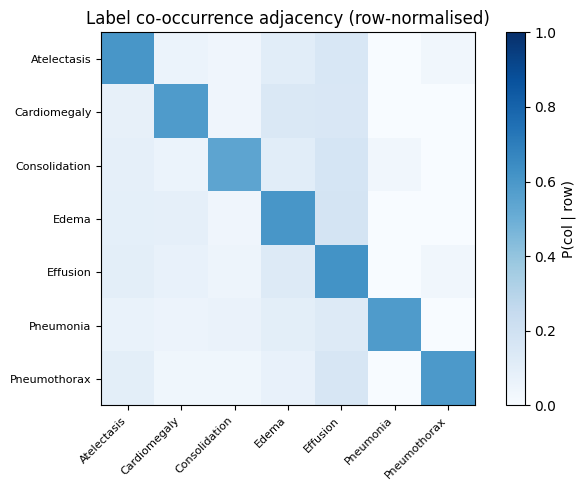

In [5]:
A = build_adjacency_matrix(Y_train, tau=0.1)
assert torch.allclose(A.sum(dim=1), torch.ones(K), atol=1e-5), "Row sums must be 1!"

print("Adjacency matrix shape:", A.shape)

fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(A.numpy(), vmin=0, vmax=1, cmap="Blues")
ax.set_xticks(range(K)); ax.set_yticks(range(K))
ax.set_xticklabels(COMMON_PATHOLOGIES, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(COMMON_PATHOLOGIES, fontsize=8)
plt.colorbar(im, ax=ax, label="P(col | row)")
ax.set_title("Label co-occurrence adjacency (row-normalised)")
plt.tight_layout()
plt.show()

## 5. Train LabelGCN + compute GNN probabilities for all splits

Training on: mps


Epoch   1/50  loss=0.4351  val_auc=0.8293


Epoch   2/50  loss=0.4255  val_auc=0.8297


Epoch   3/50  loss=0.4218  val_auc=0.8291


Epoch   4/50  loss=0.4182  val_auc=0.8293


Epoch   5/50  loss=0.4148  val_auc=0.8294


Epoch   6/50  loss=0.4122  val_auc=0.8287


Epoch   7/50  loss=0.4093  val_auc=0.8304


Epoch   8/50  loss=0.4072  val_auc=0.8300


Epoch   9/50  loss=0.4055  val_auc=0.8306


Epoch  10/50  loss=0.4036  val_auc=0.8300


Epoch  11/50  loss=0.4016  val_auc=0.8296


Epoch  12/50  loss=0.4009  val_auc=0.8303


Epoch  13/50  loss=0.3989  val_auc=0.8316


Epoch  14/50  loss=0.3982  val_auc=0.8304


Epoch  15/50  loss=0.3967  val_auc=0.8305


Epoch  16/50  loss=0.3957  val_auc=0.8313


Epoch  17/50  loss=0.3951  val_auc=0.8316


Epoch  18/50  loss=0.3939  val_auc=0.8324


Epoch  19/50  loss=0.3932  val_auc=0.8314


Epoch  20/50  loss=0.3923  val_auc=0.8325


Epoch  21/50  loss=0.3915  val_auc=0.8313


Epoch  22/50  loss=0.3909  val_auc=0.8311


Epoch  23/50  loss=0.3905  val_auc=0.8305


Epoch  24/50  loss=0.3900  val_auc=0.8310


Epoch  25/50  loss=0.3893  val_auc=0.8317


Epoch  26/50  loss=0.3892  val_auc=0.8311


Epoch  27/50  loss=0.3885  val_auc=0.8301


Epoch  28/50  loss=0.3882  val_auc=0.8316


Epoch  29/50  loss=0.3880  val_auc=0.8314


Epoch  30/50  loss=0.3877  val_auc=0.8309


Epoch  31/50  loss=0.3870  val_auc=0.8316


Epoch  32/50  loss=0.3869  val_auc=0.8313


Epoch  33/50  loss=0.3866  val_auc=0.8312


Epoch  34/50  loss=0.3866  val_auc=0.8310


Epoch  35/50  loss=0.3858  val_auc=0.8294


Epoch  36/50  loss=0.3856  val_auc=0.8311


Epoch  37/50  loss=0.3855  val_auc=0.8308


Epoch  38/50  loss=0.3851  val_auc=0.8310


Epoch  39/50  loss=0.3854  val_auc=0.8314


Epoch  40/50  loss=0.3853  val_auc=0.8301


Epoch  41/50  loss=0.3850  val_auc=0.8305


Epoch  42/50  loss=0.3846  val_auc=0.8307


Epoch  43/50  loss=0.3847  val_auc=0.8294


Epoch  44/50  loss=0.3844  val_auc=0.8294


Epoch  45/50  loss=0.3840  val_auc=0.8297


Epoch  46/50  loss=0.3844  val_auc=0.8303


Epoch  47/50  loss=0.3838  val_auc=0.8304


Epoch  48/50  loss=0.3837  val_auc=0.8301


Epoch  49/50  loss=0.3836  val_auc=0.8290


Epoch  50/50  loss=0.3836  val_auc=0.8290


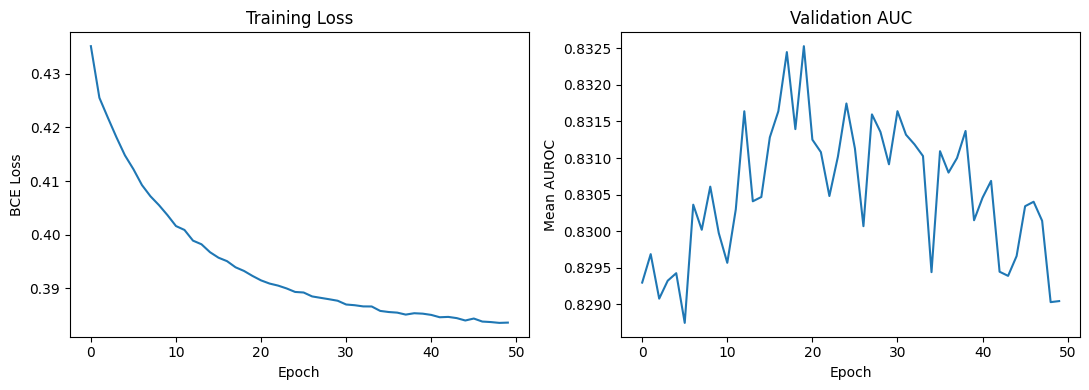

Best val AUC: 0.8325 at epoch 20


In [6]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print("Training on:", DEVICE)

# LR logits used as residual init to stabilise early training
init_logits_train = get_logits_lr(lrs, Xtr_s)
init_logits_cal   = get_logits_lr(lrs, Xcal_s)
init_logits_nih   = get_logits_lr(lrs, Xnih_s)
init_logits_pool  = get_logits_lr(lrs, Xpool_s)

gnn_model, history = train_gnn(
    features_train=Xtr_s,
    labels_train=Y_train,
    features_val=Xcal_s,
    labels_val=Y_cal,
    adjacency=A,
    init_logits_train=init_logits_train,
    init_logits_val=init_logits_cal,
    epochs=50,
    batch_size=512,
    lr=1e-3,
    weight_decay=1e-4,
    device=DEVICE,
    verbose=True,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.plot(history["train_loss"])
ax1.set_xlabel("Epoch"); ax1.set_ylabel("BCE Loss"); ax1.set_title("Training Loss")
ax2.plot(history["val_auc"])
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Mean AUROC"); ax2.set_title("Validation AUC")
plt.tight_layout()
plt.show()
print(f"Best val AUC: {max(history['val_auc']):.4f} at epoch {np.argmax(history['val_auc'])+1}")

In [7]:
def gnn_predict_probs(model, features_scaled, init_logits_np=None):
    """Run GNN on numpy features, return [N, K] sigmoid probabilities."""
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(features_scaled, dtype=torch.float32)
        init_t = (torch.tensor(init_logits_np, dtype=torch.float32)
                  if init_logits_np is not None else None)
        logits = model(X_t, init_t).numpy()
    return 1.0 / (1.0 + np.exp(-logits))

# For SCRC calibration and evaluation
probs_cal_gnn  = gnn_predict_probs(gnn_model, Xcal_s,  init_logits_cal)
probs_nih_gnn  = gnn_predict_probs(gnn_model, Xnih_s,  init_logits_nih)

# For DRE-C: GNN probs representing source (train) and target (pool) domains
probs_train_gnn = gnn_predict_probs(gnn_model, Xtr_s,   init_logits_train)  # [N_train, 7]
probs_pool_gnn  = gnn_predict_probs(gnn_model, Xpool_s, init_logits_pool)   # [N_pool,  7]

print("GNN probs shapes:")
print(f"  cal:   {probs_cal_gnn.shape}   pool:  {probs_pool_gnn.shape}")
print(f"  train: {probs_train_gnn.shape}  nih:   {probs_nih_gnn.shape}")
assert probs_nih_gnn.min() >= 0 and probs_nih_gnn.max() <= 1

GNN probs shapes:
  cal:   (12906, 7)   pool:  (15402, 7)
  train: (38720, 7)  nih:   (15403, 7)


## 6. AUC comparison: LR vs GNN on NIH test

In [8]:
rows = []
for k, path in enumerate(COMMON_PATHOLOGIES):
    valid = ~np.isnan(Y_nih_test[:, k])
    if valid.sum() < 2 or len(np.unique(Y_nih_test[valid, k])) < 2:
        rows.append({"Pathology": path, "LR": float("nan"), "GNN": float("nan")})
        continue
    yv = Y_nih_test[valid, k]
    rows.append({
        "Pathology": path,
        "LR":  roc_auc_score(yv, probs_nih_lr[valid, k]),
        "GNN": roc_auc_score(yv, probs_nih_gnn[valid, k]),
    })

auc_df = pd.DataFrame(rows).set_index("Pathology")
print("=== NIH Test AUC: LR vs GNN ===")
print(auc_df.round(4))
print(f"\nMean AUC — LR: {auc_df['LR'].mean():.4f}   GNN: {auc_df['GNN'].mean():.4f}")

=== NIH Test AUC: LR vs GNN ===
                   LR     GNN
Pathology                    
Atelectasis    0.6868  0.6977
Cardiomegaly   0.7393  0.7590
Consolidation  0.7252  0.7442
Edema          0.8163  0.8213
Effusion       0.8031  0.8166
Pneumonia      0.6286  0.6648
Pneumothorax   0.5674  0.5813

Mean AUC — LR: 0.7095   GNN: 0.7264


## 7. Density Ratio Estimation

- **DRE-A**: 1024-dim scaled features, PCA(4), no clip
- **DRE-B**: 1024-dim scaled features, no PCA, no clip
- **DRE-C**: 7-dim GNN probability space, no PCA, no clip

All three: source = CheXpert train, target = NIH pool. No weight clipping (`weight_clip=None`).

In [9]:
# DRE-A: 1024-dim, PCA(4), no clip
dre_a = AdaptiveDRE(n_components=4, weight_clip=None, random_state=SEED)
dre_a.fit(source_features=Xtr_s, target_features=Xpool_s)

w_cal_A = dre_a.compute_weights(Xcal_s)
diag_a  = dre_a.diagnostics(Xcal_s)

print("=== DRE-A: 1024-dim, PCA(4), no clip ===")
print(f"  Domain AUC: {diag_a.domain_auc:.4f}")
print(f"  ESS (cal):  {diag_a.ess:.1f}  ({diag_a.ess_fraction*100:.1f}%)")
print(f"  Weights  — mean={diag_a.weight_mean:.3f}  median={diag_a.weight_median:.3f}  "
      f"min={diag_a.weight_min:.4f}  max={diag_a.weight_max:.3f}")

=== DRE-A: 1024-dim, PCA(4), no clip ===
  Domain AUC: 0.9207
  ESS (cal):  1018.9  (7.9%)
  Weights  — mean=0.763  median=0.144  min=0.0000  max=94.050


In [10]:
# DRE-B: 1024-dim, no PCA, no clip
dre_b = AdaptiveDRE(n_components=None, weight_clip=None, random_state=SEED)
dre_b.fit(source_features=Xtr_s, target_features=Xpool_s)

w_cal_B = dre_b.compute_weights(Xcal_s)
diag_b  = dre_b.diagnostics(Xcal_s)

print("=== DRE-B: 1024-dim, no PCA, no clip ===")
print(f"  Domain AUC: {diag_b.domain_auc:.4f}")
print(f"  ESS (cal):  {diag_b.ess:.1f}  ({diag_b.ess_fraction*100:.1f}%)")
print(f"  Weights  — mean={diag_b.weight_mean:.3f}  median={diag_b.weight_median:.3f}  "
      f"min={diag_b.weight_min:.4f}  max={diag_b.weight_max:.3f}")

=== DRE-B: 1024-dim, no PCA, no clip ===
  Domain AUC: 1.0000
  ESS (cal):  1.0  (0.0%)
  Weights  — mean=1.722  median=0.000  min=0.0000  max=21990.209


In [11]:
# DRE-C: 7-dim GNN probability space, no PCA, no clip
# Domain classifier now distinguishes CheXpert vs NIH in semantic prediction space.
dre_c = AdaptiveDRE(n_components=None, weight_clip=None, random_state=SEED)
dre_c.fit(source_features=probs_train_gnn, target_features=probs_pool_gnn)

# Weights on calibration set: pass the GNN probs (not raw features)
w_cal_C = dre_c.compute_weights(probs_cal_gnn)
diag_c  = dre_c.diagnostics(probs_cal_gnn)

print("=== DRE-C: 7-dim GNN probs, no PCA, no clip ===")
print(f"  Domain AUC: {diag_c.domain_auc:.4f}")
print(f"  ESS (cal):  {diag_c.ess:.1f}  ({diag_c.ess_fraction*100:.1f}%)")
print(f"  Weights  — mean={diag_c.weight_mean:.3f}  median={diag_c.weight_median:.3f}  "
      f"min={diag_c.weight_min:.4f}  max={diag_c.weight_max:.3f}")

=== DRE-C: 7-dim GNN probs, no PCA, no clip ===
  Domain AUC: 0.8567
  ESS (cal):  2764.1  (21.4%)
  Weights  — mean=0.952  median=0.334  min=0.0000  max=128.894


## 8. SCRC calibration and test evaluation

In [12]:
BETA  = 0.15   # deferral budget
ALPHA = 0.10   # FNR target

# Method A: LR probs + DRE-A weights
scrc_a = PerPathologySCRCPredictor(beta=BETA, alpha=ALPHA, seed=SEED)
crc_a  = scrc_a.calibrate(
    cal_probs=probs_cal_lr,
    cal_labels=Y_cal,
    cal_weights=w_cal_A,
    pathology_names=COMMON_PATHOLOGIES,
)
result_a = scrc_a.predict(probs_nih_lr)

print("=== Method A: LR + DRE-A (1024-dim, PCA-4, no clip) ===")
print(f"Deferral rate: {result_a.deferral_rate:.3f}")
print(f"Lambda hats:  {dict(zip(COMMON_PATHOLOGIES, crc_a.lambda_hats.round(3)))}")
print(f"Weighted FNR: {dict(zip(COMMON_PATHOLOGIES, crc_a.weighted_fnr_at_lambda.round(3)))}")

=== Method A: LR + DRE-A (1024-dim, PCA-4, no clip) ===
Deferral rate: 0.150
Lambda hats:  {'Atelectasis': np.float64(0.113), 'Cardiomegaly': np.float64(0.027), 'Consolidation': np.float64(0.01), 'Edema': np.float64(0.055), 'Effusion': np.float64(0.068), 'Pneumonia': np.float64(0.006), 'Pneumothorax': np.float64(0.013)}
Weighted FNR: {'Atelectasis': np.float64(0.099), 'Cardiomegaly': np.float64(0.097), 'Consolidation': np.float64(0.097), 'Edema': np.float64(0.093), 'Effusion': np.float64(0.1), 'Pneumonia': np.float64(0.099), 'Pneumothorax': np.float64(0.1)}


In [13]:
# Method B: LR probs + DRE-B weights
scrc_b = PerPathologySCRCPredictor(beta=BETA, alpha=ALPHA, seed=SEED)
crc_b  = scrc_b.calibrate(
    cal_probs=probs_cal_lr,
    cal_labels=Y_cal,
    cal_weights=w_cal_B,
    pathology_names=COMMON_PATHOLOGIES,
)
result_b = scrc_b.predict(probs_nih_lr)

print("=== Method B: LR + DRE-B (1024-dim, no PCA, no clip) ===")
print(f"Deferral rate: {result_b.deferral_rate:.3f}")
print(f"Lambda hats:  {dict(zip(COMMON_PATHOLOGIES, crc_b.lambda_hats.round(3)))}")
print(f"Weighted FNR: {dict(zip(COMMON_PATHOLOGIES, crc_b.weighted_fnr_at_lambda.round(3)))}")

=== Method B: LR + DRE-B (1024-dim, no PCA, no clip) ===
Deferral rate: 0.150
Lambda hats:  {'Atelectasis': np.float64(0.085), 'Cardiomegaly': np.float64(0.49), 'Consolidation': np.float64(0.33), 'Edema': np.float64(0.501), 'Effusion': np.float64(0.262), 'Pneumonia': np.float64(0.118), 'Pneumothorax': np.float64(0.012)}
Weighted FNR: {'Atelectasis': np.float64(0.014), 'Cardiomegaly': np.float64(0.042), 'Consolidation': np.float64(0.099), 'Edema': np.float64(0.054), 'Effusion': np.float64(0.012), 'Pneumonia': np.float64(0.098), 'Pneumothorax': np.float64(0.022)}


In [14]:
# Method C: GNN probs + DRE-C weights
scrc_c = PerPathologySCRCPredictor(beta=BETA, alpha=ALPHA, seed=SEED)
crc_c  = scrc_c.calibrate(
    cal_probs=probs_cal_gnn,
    cal_labels=Y_cal,
    cal_weights=w_cal_C,
    pathology_names=COMMON_PATHOLOGIES,
)
result_c = scrc_c.predict(probs_nih_gnn)

print("=== Method C: GNN + DRE-C (7-dim GNN probs, no clip) ===")
print(f"Deferral rate: {result_c.deferral_rate:.3f}")
print(f"Lambda hats:  {dict(zip(COMMON_PATHOLOGIES, crc_c.lambda_hats.round(3)))}")
print(f"Weighted FNR: {dict(zip(COMMON_PATHOLOGIES, crc_c.weighted_fnr_at_lambda.round(3)))}")

=== Method C: GNN + DRE-C (7-dim GNN probs, no clip) ===
Deferral rate: 0.150
Lambda hats:  {'Atelectasis': np.float64(0.125), 'Cardiomegaly': np.float64(0.049), 'Consolidation': np.float64(0.017), 'Edema': np.float64(0.069), 'Effusion': np.float64(0.065), 'Pneumonia': np.float64(0.021), 'Pneumothorax': np.float64(0.027)}
Weighted FNR: {'Atelectasis': np.float64(0.1), 'Cardiomegaly': np.float64(0.1), 'Consolidation': np.float64(0.094), 'Edema': np.float64(0.1), 'Effusion': np.float64(0.1), 'Pneumonia': np.float64(0.088), 'Pneumothorax': np.float64(0.096)}


## 9. Per-pathology results table

In [15]:
def compute_empirical_metrics(result, y_nih):
    """Per-pathology empirical FNR and PPR on non-deferred NIH test."""
    kept = ~result.defer_mask
    rows = []
    for k, path in enumerate(COMMON_PATHOLOGIES):
        valid_kept = (~np.isnan(y_nih[:, k])) & kept
        if valid_kept.sum() == 0:
            rows.append({"Pathology": path, "empirical_FNR": float("nan"), "PPR": float("nan")})
            continue
        y_k    = y_nih[valid_kept, k]
        pred_k = result.prediction_sets[valid_kept, k]
        tp  = ((pred_k == 1) & (y_k == 1)).sum()
        fn  = ((pred_k == 0) & (y_k == 1)).sum()
        fnr = fn / max(1, tp + fn)
        rows.append({"Pathology": path, "empirical_FNR": round(fnr, 4), "PPR": round(pred_k.mean(), 4)})
    return pd.DataFrame(rows).set_index("Pathology")

m_a = compute_empirical_metrics(result_a, Y_nih_test)
m_b = compute_empirical_metrics(result_b, Y_nih_test)
m_c = compute_empirical_metrics(result_c, Y_nih_test)

summary = pd.DataFrame({
    "AUC_LR":    auc_df["LR"],
    "AUC_GNN":   auc_df["GNN"],
    "lam_A":     pd.Series(dict(zip(COMMON_PATHOLOGIES, crc_a.lambda_hats.round(3)))),
    "lam_B":     pd.Series(dict(zip(COMMON_PATHOLOGIES, crc_b.lambda_hats.round(3)))),
    "lam_C":     pd.Series(dict(zip(COMMON_PATHOLOGIES, crc_c.lambda_hats.round(3)))),
    "wFNR_A":    pd.Series(dict(zip(COMMON_PATHOLOGIES, crc_a.weighted_fnr_at_lambda.round(3)))),
    "wFNR_B":    pd.Series(dict(zip(COMMON_PATHOLOGIES, crc_b.weighted_fnr_at_lambda.round(3)))),
    "wFNR_C":    pd.Series(dict(zip(COMMON_PATHOLOGIES, crc_c.weighted_fnr_at_lambda.round(3)))),
    "FNR_A":     m_a["empirical_FNR"],
    "FNR_B":     m_b["empirical_FNR"],
    "FNR_C":     m_c["empirical_FNR"],
    "PPR_A":     m_a["PPR"],
    "PPR_B":     m_b["PPR"],
    "PPR_C":     m_c["PPR"],
})

print(f"Deferral rates — A: {result_a.deferral_rate:.3f}  B: {result_b.deferral_rate:.3f}  "
      f"C: {result_c.deferral_rate:.3f}")
print("\n=== Per-pathology summary (NIH test) ===")
print(summary.round(4).to_string())

Deferral rates — A: 0.150  B: 0.150  C: 0.150

=== Per-pathology summary (NIH test) ===
               AUC_LR  AUC_GNN  lam_A  lam_B  lam_C  wFNR_A  wFNR_B  wFNR_C   FNR_A   FNR_B   FNR_C   PPR_A   PPR_B   PPR_C
Atelectasis    0.6868   0.6977  0.113  0.085  0.125   0.099   0.014   0.100  0.3125  0.2196  0.2300  0.4575  0.5682  0.5430
Cardiomegaly   0.7393   0.7590  0.027  0.490  0.049   0.097   0.042   0.100  0.2955  0.8864  0.2205  0.4027  0.0274  0.4201
Consolidation  0.7252   0.7442  0.010  0.330  0.017   0.097   0.099   0.094  0.3246  0.9123  0.2655  0.4471  0.0139  0.4917
Edema          0.8163   0.8213  0.055  0.501  0.069   0.093   0.054   0.100  0.2222  0.6111  0.2105  0.5215  0.0488  0.4959
Effusion       0.8031   0.8166  0.068  0.262  0.065   0.100   0.012   0.100  0.2281  0.6156  0.1712  0.4929  0.0843  0.5655
Pneumonia      0.6286   0.6648  0.006  0.118  0.021   0.099   0.098   0.088  0.1875  0.8333  0.2292  0.7601  0.1667  0.6653
Pneumothorax   0.5674   0.5813  0.013  0.012

## 10. DRE diagnostics comparison

=== DRE Diagnostics Comparison ===
                     Domain AUC     ESS   ESS%  W mean  W median      W max
DRE                                                                        
A: 1024-dim, PCA-4       0.9207  1018.9   7.89   0.763     0.144     94.050
B: 1024-dim, no-PCA      1.0000     1.0   0.01   1.722     0.000  21990.209
C: 7-dim GNN probs       0.8567  2764.1  21.42   0.952     0.334    128.894


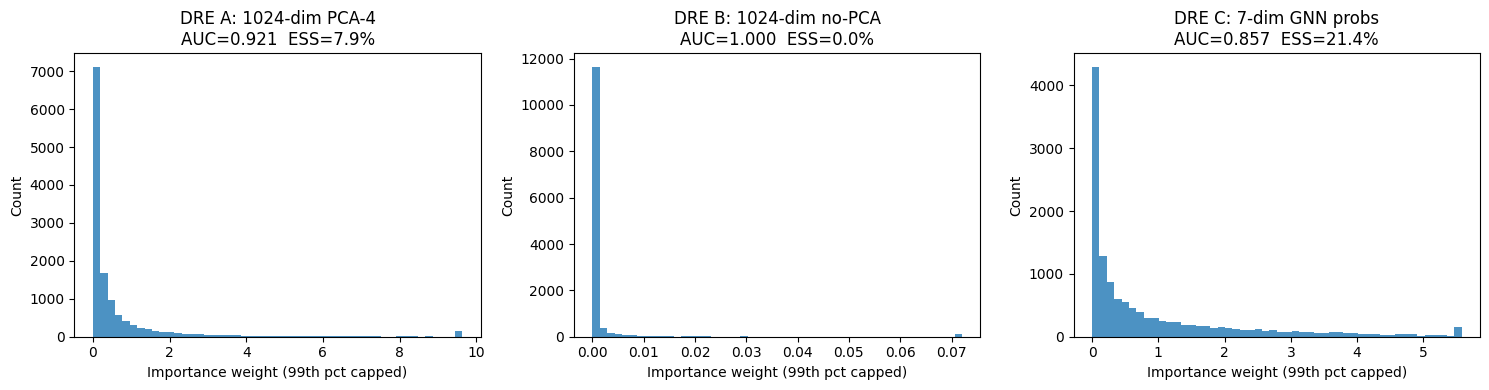

In [16]:
diag_rows = [
    {"DRE": "A: 1024-dim, PCA-4",    "Domain AUC": round(diag_a.domain_auc, 4),
     "ESS": round(diag_a.ess, 1),    "ESS%": round(diag_a.ess_fraction * 100, 2),
     "W mean": round(diag_a.weight_mean, 3), "W median": round(diag_a.weight_median, 3),
     "W max": round(diag_a.weight_max, 3)},
    {"DRE": "B: 1024-dim, no-PCA",   "Domain AUC": round(diag_b.domain_auc, 4),
     "ESS": round(diag_b.ess, 1),    "ESS%": round(diag_b.ess_fraction * 100, 2),
     "W mean": round(diag_b.weight_mean, 3), "W median": round(diag_b.weight_median, 3),
     "W max": round(diag_b.weight_max, 3)},
    {"DRE": "C: 7-dim GNN probs",    "Domain AUC": round(diag_c.domain_auc, 4),
     "ESS": round(diag_c.ess, 1),    "ESS%": round(diag_c.ess_fraction * 100, 2),
     "W mean": round(diag_c.weight_mean, 3), "W median": round(diag_c.weight_median, 3),
     "W max": round(diag_c.weight_max, 3)},
]
diag_df = pd.DataFrame(diag_rows).set_index("DRE")
print("=== DRE Diagnostics Comparison ===")
print(diag_df.to_string())

# Weight distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, w, diag) in zip(axes, [
    ("A: 1024-dim PCA-4",  w_cal_A, diag_a),
    ("B: 1024-dim no-PCA", w_cal_B, diag_b),
    ("C: 7-dim GNN probs", w_cal_C, diag_c),
]):
    cap = np.percentile(w, 99)
    ax.hist(np.clip(w, 0, cap), bins=50, edgecolor="none", alpha=0.8)
    ax.set_title(f"DRE {name}\nAUC={diag.domain_auc:.3f}  ESS={diag.ess_fraction*100:.1f}%")
    ax.set_xlabel("Importance weight (99th pct capped)")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

## 11. Beta sweep (0.05 – 0.40)

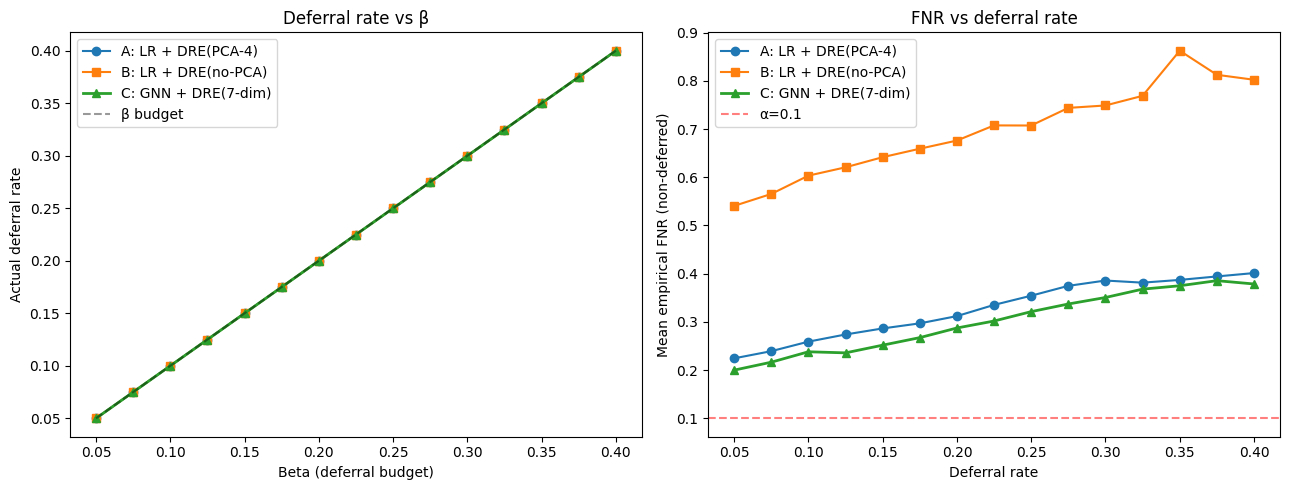

In [17]:
betas = np.linspace(0.05, 0.40, 15)

def sweep_beta_method(probs_cal, labels_cal, weights_cal, probs_test, labels_test,
                      betas=betas, alpha=ALPHA):
    """Sweep deferral budget beta; return (deferral_rates, mean_fnrs)."""
    defer_rates, mean_fnrs = [], []
    for beta in betas:
        scrc = PerPathologySCRCPredictor(beta=beta, alpha=alpha, seed=SEED)
        scrc.calibrate(probs_cal, labels_cal, weights_cal)
        res = scrc.predict(probs_test)
        defer_rates.append(res.deferral_rate)
        kept = ~res.defer_mask
        fnrs = []
        for k in range(K):
            valid = ~np.isnan(labels_test[:, k]) & kept
            if valid.sum() == 0:
                continue
            yv = labels_test[valid, k]
            pv = res.prediction_sets[valid, k]
            fn = ((pv == 0) & (yv == 1)).sum()
            tp = ((pv == 1) & (yv == 1)).sum()
            if tp + fn > 0:
                fnrs.append(fn / (tp + fn))
        mean_fnrs.append(np.mean(fnrs) if fnrs else float("nan"))
    return np.array(defer_rates), np.array(mean_fnrs)

dr_a, fnr_a = sweep_beta_method(probs_cal_lr,  Y_cal, w_cal_A, probs_nih_lr,  Y_nih_test)
dr_b, fnr_b = sweep_beta_method(probs_cal_lr,  Y_cal, w_cal_B, probs_nih_lr,  Y_nih_test)
dr_c, fnr_c = sweep_beta_method(probs_cal_gnn, Y_cal, w_cal_C, probs_nih_gnn, Y_nih_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.plot(betas, dr_a, "o-",  label="A: LR + DRE(PCA-4)")
ax1.plot(betas, dr_b, "s-",  label="B: LR + DRE(no-PCA)")
ax1.plot(betas, dr_c, "^-",  label="C: GNN + DRE(7-dim)", linewidth=2)
ax1.plot(betas, betas, "k--", alpha=0.4, label="\u03b2 budget")
ax1.set_xlabel("Beta (deferral budget)"); ax1.set_ylabel("Actual deferral rate")
ax1.set_title("Deferral rate vs \u03b2"); ax1.legend()

ax2.plot(dr_a, fnr_a, "o-",  label="A: LR + DRE(PCA-4)")
ax2.plot(dr_b, fnr_b, "s-",  label="B: LR + DRE(no-PCA)")
ax2.plot(dr_c, fnr_c, "^-",  label="C: GNN + DRE(7-dim)", linewidth=2)
ax2.axhline(ALPHA, color="red", linestyle="--", alpha=0.5, label=f"\u03b1={ALPHA}")
ax2.set_xlabel("Deferral rate"); ax2.set_ylabel("Mean empirical FNR (non-deferred)")
ax2.set_title("FNR vs deferral rate"); ax2.legend()

plt.tight_layout()
plt.show()

## 12. Summary

In [18]:
print(f"\n{'='*72}")
print(f"SCRC Experiment Summary  (\u03b2={BETA}, \u03b1={ALPHA})")
print(f"{'='*72}")
print(f"{'Method':<30} {'Deferral':>9} {'Mean AUC':>10} {'Mean FNR':>10} {'Mean PPR':>10}")
print("-" * 72)

for label, res, auc_col, m in [
    ("A: LR + DRE(1024, PCA-4)",  result_a, "LR",  m_a),
    ("B: LR + DRE(1024, no-PCA)", result_b, "LR",  m_b),
    ("C: GNN + DRE(7-dim)",        result_c, "GNN", m_c),
]:
    mean_auc = auc_df[auc_col].dropna().mean()
    mean_fnr = m["empirical_FNR"].dropna().mean()
    mean_ppr = m["PPR"].dropna().mean()
    print(f"{label:<30} {res.deferral_rate:>9.3f} {mean_auc:>10.4f} {mean_fnr:>10.4f} {mean_ppr:>10.4f}")

print(f"\n{'='*72}")
print("DRE diagnostics:")
print(diag_df.to_string())
print(f"\n{'='*72}")
print("Per-pathology AUC (NIH test):")
print(auc_df.round(4).to_string())


SCRC Experiment Summary  (β=0.15, α=0.1)
Method                          Deferral   Mean AUC   Mean FNR   Mean PPR
------------------------------------------------------------------------
A: LR + DRE(1024, PCA-4)           0.150     0.7095     0.2865     0.5110
B: LR + DRE(1024, no-PCA)          0.150     0.7095     0.6416     0.2042
C: GNN + DRE(7-dim)                0.150     0.7264     0.2517     0.5292

DRE diagnostics:
                     Domain AUC     ESS   ESS%  W mean  W median      W max
DRE                                                                        
A: 1024-dim, PCA-4       0.9207  1018.9   7.89   0.763     0.144     94.050
B: 1024-dim, no-PCA      1.0000     1.0   0.01   1.722     0.000  21990.209
C: 7-dim GNN probs       0.8567  2764.1  21.42   0.952     0.334    128.894

Per-pathology AUC (NIH test):
                   LR     GNN
Pathology                    
Atelectasis    0.6868  0.6977
Cardiomegaly   0.7393  0.7590
Consolidation  0.7252  0.7442
Edema     